In [7]:
import findspark
findspark.init()

In [8]:
import pyspark
from pyspark.sql import functions

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [10]:
# @hidden_cell

user='leon.zhao@offerupnow.com'
password='Steel24ly@offerup'
account='offerup'

In [18]:
import snowflake.connector


class SnowflakeSession:

    def __init__(self, user, password, account):

        # Connect and get cursor
        print("> Connecting to Snowflake")
        self.ctx = snowflake.connector.connect(user=user,
                                                password=password,
                                                account=account, )
        self.cs = self.ctx.cursor()

        # Set up cursor
        self.cs.execute("use warehouse analytics_wh;")
        self.cs.execute("use role marketing;")
        self.cs.execute("Alter session set timezone = 'America/Los_Angeles';") # for TZ aware fields

    @staticmethod
    def parse_query_file(sql_query_file):
        """Parse SQL file and return query as string."""
        
        # Reading of the SQL statement from sql_query.txt file
        print("> Reading SQL statement from file")
        fd = open(sql_query_file, 'r')
        sqlFile = fd.read()
        fd.close()

        # Extraction of the SQL statement (split on ';')
        # Get only the first statement.
        sql_sentence_list = sqlFile.split(';')
        sql_query = [x for x in sql_sentence_list if x][0]

        return sql_query

    def execute_query(self, qry):
        print("> Querying database with:")
        print(qry)
        print("\n> Fetching data ...")
        self.cs.execute(qry)
        colnames = [x[0] for x in self.cs.description]
        rows = self.cs.fetchall()
        return rows, colnames

    @staticmethod
    def result_to_df(rows, colnames):
        print("> Saving to dataframe ...")
        df =  pd.DataFrame(rows, columns=colnames)
        df.replace({r'\r': ''}, regex=True, inplace=True)
        return df


    @staticmethod
    def save_df_to_csv(df, fname):
        print("\n> Saving to file ...")
        if '.csv' in fname:
            separator = ','
        else:
            separator = '\t'
        df.to_csv(fname, index=False, sep=separator, header=True, encoding='utf-8')

    def close_session(self):
        print("\n> Closing session ...")
        self.cs.close()
        self.ctx.close()
        
s = SnowflakeSession(user, password, account)

> Connecting to Snowflake


In [34]:
data = s.parse_query_file('/Users/leon.zhao/Desktop/SQL/items_posted_daliy.sql')
print(data)
rows, colnames = s.execute_query(data)

> Reading SQL statement from file
SELECT *
FROM OUBI.METRICS.DAILY_METRICS_AGGREGATES_COLUMNAR
ORDER BY 1 ASC

> Querying database with:
SELECT *
FROM OUBI.METRICS.DAILY_METRICS_AGGREGATES_COLUMNAR
ORDER BY 1 ASC


> Fetching data ...


In [74]:
df = pd.DataFrame(data = rows, columns = colnames)
df['ACTIVITY_DATE_PACIFIC_TIME'] = pd.to_datetime(df['ACTIVITY_DATE_PACIFIC_TIME'])
# df.info()
df.head()

,ACTIVITY_DATE_PACIFIC_TIME,AD_CLICKS,ADS_REQUESTED,ADS_RETURNED,ADS_SHOWN,BING_ADS_REVENUE,BUMP_REVENUE,BUMPS,BUMPERS,BUYER_ITEM_VIEWS,...,EXTERNAL_ADS_REVENUE,GOOGLE_PLAY_BUMP_REVENUE,GOOGLE_PLAY_LISTING_FEES,GOOGLE_PLAY_SELLER_AD_REVENUE,GOOGLE_PLAY_SELLER_AD_SUBSCRIPTION_REVENUE,CASHLESS_PAYMENTS_REVENUE,LABELS_SHIPPING_REVENUE,PAYMENTS_SHIPPING_REVENUE,WEB_INTERNAL_AD_PURCHASES_REVENUE,ENGAGEMENTS_24HR_RESPONSE
0,2015-01-01,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0.0,...,None,None,None,None,None,None,None,None,None,NaN
1,2015-01-02,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0.0,...,None,None,None,None,None,None,None,None,None,NaN
2,2015-01-03,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0.0,...,None,None,None,None,None,None,None,None,None,NaN
3,2015-01-04,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0.0,...,None,None,None,None,None,None,None,None,None,NaN
4,2015-01-05,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0.0,...,None,None,None,None,None,None,None,None,None,NaN


In [183]:
items_posted = df.loc[:, ['ACTIVITY_DATE_PACIFIC_TIME','ITEMS_POSTED']]
items_posted = items_posted[(items_posted['ACTIVITY_DATE_PACIFIC_TIME'] > '2018-01-01') & (items_posted['ACTIVITY_DATE_PACIFIC_TIME'] < '2019-02-22')]
items_posted.head()

,ACTIVITY_DATE_PACIFIC_TIME,ITEMS_POSTED
1097,2018-01-02,512939.0
1098,2018-01-03,510115.0
1099,2018-01-04,513052.0
1100,2018-01-05,516855.0
1101,2018-01-06,582300.0


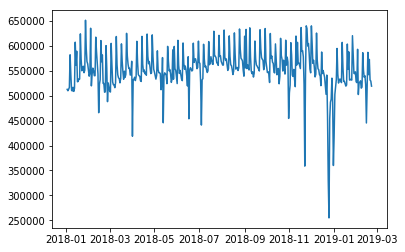

In [184]:
plt.plot(items_posted.iloc[:,0], items_posted.iloc[:,1])

In [207]:
# rolling = items_posted['ITEMS_POSTED'].rolling(window=7)
# items_posted['rolling_mean'] = rolling.mean()
# items_posted.head(15)



width = 7
items_posted['lag1'] = items_posted['ITEMS_POSTED'].shift(1)
items_posted['lag7'] = items_posted['ITEMS_POSTED'].shift(width)
items_posted['7day_change'] = items_posted['ITEMS_POSTED'].shift(width)/items_posted['ITEMS_POSTED']-1
items_posted['day_of_week'] = items_posted['ACTIVITY_DATE_PACIFIC_TIME'].dt.day_name()
window = items_posted['ITEMS_POSTED'].rolling(window=width+1)
items_posted['rolling_mean'] = window.mean()
items_posted['rolling_median'] = window.median()
items_posted.head(15)

,ACTIVITY_DATE_PACIFIC_TIME,ITEMS_POSTED,lag1,lag7,7day_change,day_of_week,rolling_mean,rolling_median
1097,2018-01-02,512939.0,NaN,NaN,NaN,Tuesday,NaN,NaN
1098,2018-01-03,510115.0,512939.0,NaN,NaN,Wednesday,NaN,NaN
1099,2018-01-04,513052.0,510115.0,NaN,NaN,Thursday,NaN,NaN
1100,2018-01-05,516855.0,513052.0,NaN,NaN,Friday,NaN,NaN
1101,2018-01-06,582300.0,516855.0,NaN,NaN,Saturday,NaN,NaN
1102,2018-01-07,542196.0,582300.0,NaN,NaN,Sunday,NaN,NaN
1103,2018-01-08,510916.0,542196.0,NaN,NaN,Monday,NaN,NaN
1104,2018-01-09,509616.0,510916.0,512939.0,0.006521,Tuesday,524748.625,512995.5
1105,2018-01-10,516998.0,509616.0,510115.0,-0.013313,Wednesday,525256.000,514953.5
1106,2018-01-11,508791.0,516998.0,513052.0,0.008375,Thursday,525090.500,514953.5


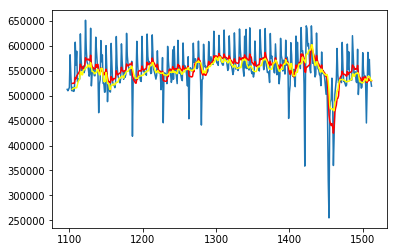

In [208]:
items_posted['ITEMS_POSTED'].plot()
items_posted['rolling_mean'].plot(color='red')
items_posted['rolling_median'].plot(color='yellow')
plt.show()

In [221]:
X = items_posted['rolling_median'].dropna().values
# print(X)
fit1 = ExponentialSmoothing(X, seasonal_periods=7, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(X, seasonal_periods=7, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(X, seasonal_periods=30, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(X, seasonal_periods=7, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
# plt.plot(fit1.fittedvalues, color='red')
# plt.plot(fit2.fittedvalues, color='green')
# plt.plot(fit1.forecast(12), color='blue',marker='o', linestyle='dashed')
# plt.plot(fit2.forecast(12), color='green',marker='o', linestyle='dashed')
# fit2.fittedvalues.plot(style='--', color='green')

# fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
# fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)

# plt.show()

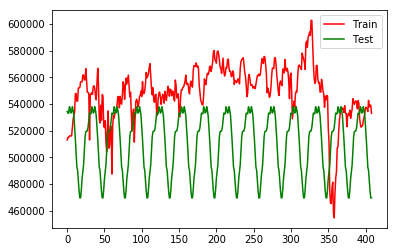

In [222]:
plt.plot(fit3.fittedvalues, color='red', label='Train')
plt.plot(fit3.forecast(len(X)), color='green', label='Test')
plt.legend(loc='best')

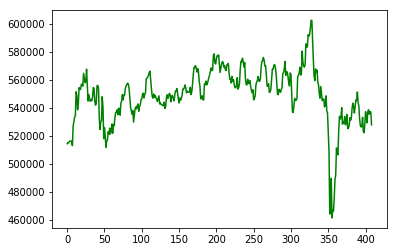

In [218]:
plt.plot(fit3.fittedvalues, color='green')

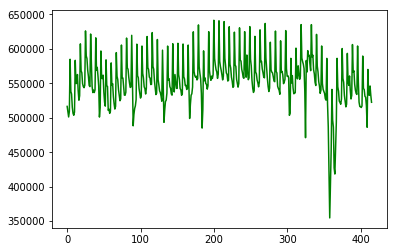

In [190]:
plt.plot(fit4.fittedvalues, color='green')